# Import Important Libraries and Dataset

In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import re

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

from sklearn import linear_model
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /home/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
raw_data = pd.read_csv("data/data.csv")
raw_data.head()

,book_id,text,birth_yr
0,84,"“And now, with the world before me, whither sh...",1797
1,84,"“You have been ill, very ill, and even the con...",1797
2,84,“I intended to reason. This passion is detrime...,1797
3,84,"“How is this? I must not be trifled with, and ...",1797
4,84,"“A few days after, the Turk entered his daught...",1797


# EDA

In [3]:
print(f"Number of books in dataset: {raw_data['book_id'].unique().shape[0]}")
print(f"Number of excerpts in dataset: {raw_data.shape[0]}")

Number of books in dataset: 1524
Number of excerpts in dataset: 8718


In [4]:
data = raw_data.copy()
data['text'] = data['text'].str.strip()
data = data.drop(4996)

,book_id,text,birth_yr,text_len
0,84,"“And now, with the world before me, whither sh...",1797,663
1,84,"“You have been ill, very ill, and even the con...",1797,931
2,84,“I intended to reason. This passion is detrime...,1797,938
3,84,"“How is this? I must not be trifled with, and ...",1797,542
4,84,"“A few days after, the Turk entered his daught...",1797,521


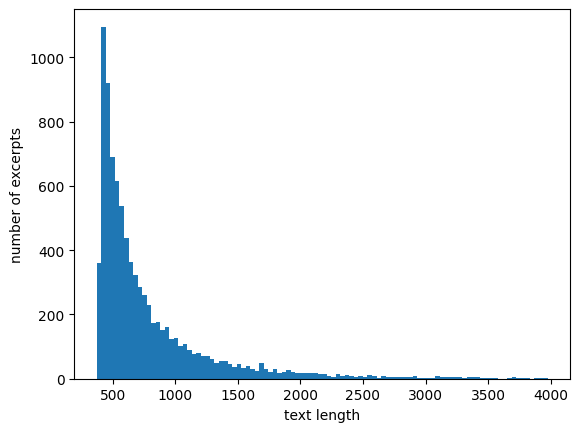

In [5]:
text_len = data['text'].str.len()
data['text_len'] = text_len
plt.hist(
    data['text_len'][data['text_len'] < 4000],
    bins = 100
)
plt.xlabel('text length')
plt.ylabel('number of excerpts')

data.head()

In [6]:
data_ctr = data[data['birth_yr'] >= 1400]
data_ctr = data_ctr[data_ctr['text_len'] <= 4000]

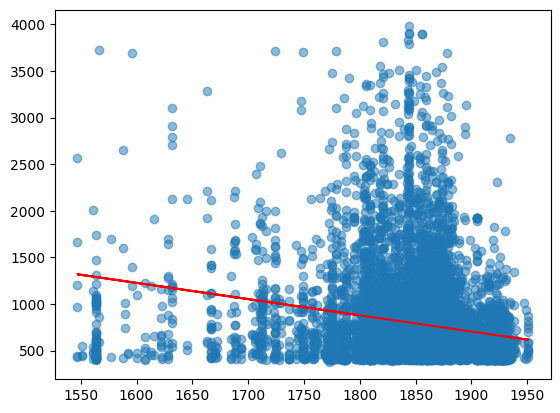

In [7]:
a, b = np.polyfit(
    data_ctr['birth_yr'].to_numpy(), 
    data_ctr['text_len'].to_numpy(), 
    1
)

plt.scatter(
    x = data_ctr['birth_yr'], 
    y = data_ctr['text_len'],
    alpha = 0.5
)

plt.plot(
    data_ctr['birth_yr'].to_numpy(), 
    a * data_ctr['birth_yr'].to_numpy() + b,
    color='red'
) 

In [8]:
text_len.describe()

count     8717.000000
mean       829.661925
std       1039.423894
min        373.000000
25%        473.000000
50%        600.000000
75%        897.000000
max      51354.000000
Name: text, dtype: float64

In [9]:
data['birth_yr'].describe()

count    8717.000000
mean     1852.802340
std        94.942837
min      -431.000000
25%      1831.000000
50%      1861.000000
75%      1893.000000
max      1951.000000
Name: birth_yr, dtype: float64

In [10]:
for i in range(1500, 2000, 100):
    num_excerpts = (
        data[
            (data['birth_yr'] >= i) & 
            (data['birth_yr'] < (i + 100))
        ].shape[0]
    )

    print(f"Timeframe: {i}-{i+100}\tNumber of Excerpts: {num_excerpts}")

Timeframe: 1500-1600	Number of Excerpts: 88
Timeframe: 1600-1700	Number of Excerpts: 136
Timeframe: 1700-1800	Number of Excerpts: 682
Timeframe: 1800-1900	Number of Excerpts: 5743
Timeframe: 1900-2000	Number of Excerpts: 2059


## Outliers

In [11]:
data[data['birth_yr'] < 1400]

,book_id,text,birth_yr,text_len
2750,71894,It was arranged that the band of volunteers sh...,-431,418
2751,71894,"Almost all the officers were of the same mind,...",-431,465
2752,71894,It was now necessary to find some means of cro...,-431,762
2753,71894,They overcame the difficulty however by means ...,-431,468
2754,71894,It was at first proposed to advance in the for...,-431,653
2755,71894,There could no longer be any doubt that the Ca...,-431,652
2756,71894,But Cyrus had long ago foreseen this difficult...,-431,443
2757,71894,"This speech made the desired impression, for t...",-431,435
2758,71894,"Best as well as last of all, was the horse-rac...",-431,587


In [12]:
data[data['text_len'] > 4000].shape

(60, 4)

# Creating Balanced Dataset

In [13]:
data_ctr['birth_ctry'] = data_ctr['birth_yr'] // 100
data_ctr.head()

,book_id,text,birth_yr,text_len,birth_ctry
0,84,"“And now, with the world before me, whither sh...",1797,663,17
1,84,"“You have been ill, very ill, and even the con...",1797,931,17
2,84,“I intended to reason. This passion is detrime...,1797,938,17
3,84,"“How is this? I must not be trifled with, and ...",1797,542,17
4,84,"“A few days after, the Turk entered his daught...",1797,521,17


In [14]:
data_balanced = (
    data_ctr
    .groupby('birth_ctry')
    .apply(
        lambda x: x.sample(2000, replace=True)
    )
    .reset_index(drop=True))

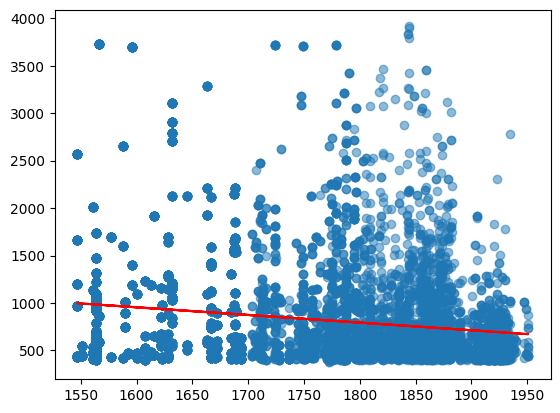

In [15]:
a, b = np.polyfit(
    data_balanced['birth_yr'].to_numpy(), 
    data_balanced['text_len'].to_numpy(), 
    1
)

plt.scatter(
    x = data_balanced['birth_yr'], 
    y = data_balanced['text_len'],
    alpha = 0.5
)

plt.plot(
    data_balanced['birth_yr'].to_numpy(), 
    a * data_balanced['birth_yr'].to_numpy() + b,
    color='red'
) 

In [16]:
data_balanced['birth_yr'].describe()

count    10000.000000
mean      1751.364400
std        130.354587
min       1547.000000
25%       1628.000000
50%       1775.000000
75%       1869.000000
max       1951.000000
Name: birth_yr, dtype: float64

In [17]:
data_balanced['text_len'].describe()

count    10000.00000
mean       832.24810
std        570.08043
min        373.00000
25%        469.00000
50%        603.00000
75%        984.25000
max       3913.00000
Name: text_len, dtype: float64

# Model Exploration

In [18]:
# Create a copy of the dataset to do text analysis on
data_tfidf = data.copy()

# Process the dataset by removing punctuation for TF-IDF
def preprocess(text):
    text = re.sub(r'[^A-Za-z0-9]+', " ", text)
    text = text.lower()
    return text
data_tfidf["text"] = data_tfidf.get("text").apply(preprocess)
data_tfidf.head()

,book_id,text,birth_yr,text_len
0,84,and now with the world before me whither shou...,1797,663
1,84,you have been ill very ill and even the const...,1797,931
2,84,i intended to reason this passion is detrimen...,1797,938
3,84,how is this i must not be trifled with and i ...,1797,542
4,84,a few days after the turk entered his daughte...,1797,521


In [31]:
def resize_text(text):
    if len(text) >= 1000:
        return text[:1000]
    else:
        return text + " " * (1000-len(text))
    
data_tfidf["text"] = data_tfidf["text"].apply(resize_text)

In [44]:
for t in data_tfidf["text"]:
    assert(len(t) == 1000)

In [32]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word',
    max_features=20000,
    tokenizer=nltk.tokenize.word_tokenize,
    stop_words=stopwords.words("english")
)

In [49]:
X = tfidf.fit_transform(data_tfidf["text"])
y = np.array(data_tfidf["birth_yr"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

min_max_scaler = MaxAbsScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [50]:
from xgboost import XGBRegressor
# read data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [51]:
model1 = XGBRegressor(n_estimators=2, max_depth=2, learning_rate=1, objective='reg:linear')
model1.fit(X_train, y_train)

/home/admin/.local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [17:45:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [52]:
y_train_pred = model1.predict(X_train)
y_test_pred = model1.predict(X_test)

In [53]:
def RMSE(y_pred, y):
    return np.sqrt(np.sum(np.square(y - y_pred)) / y.shape[0])

In [54]:
print(f"Training RMSE: {RMSE(y_train_pred, y_train)}")
print(f"Test RMSE: {RMSE(y_test_pred, y_test)}")

Training RMSE: 72.09327374612718
Test RMSE: 85.49819396886097


In [55]:
y_pred_rand = np.random.randint(1500, 1999, size=y_test.shape[0])
print(f"Random Guessing RMSE: {RMSE(y_pred_rand, y_test)}")

Random Guessing RMSE: 212.07123905843483


In [56]:
# General data analysis/plotting
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split

# Neural Net modules
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

import tensorflow as tf

In [ ]:
# build the model!
model = Sequential()
model.add(Dense(1000, input_shape=(X_train.shape[1],), activation='relu')) # (features,)
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='linear')) # output node
model.summary() # see what your model looks like

# compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# early stopping callback
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True)

# # sort indices
X_train = tf.sparse.reorder(tf.sparse.SparseTensor(X_train))
X_test = tf.sparse.reorder(tf.sparse.SparseTensor(X_test))
Y_train = tf.sparse.reorder(tf.sparse.SparseTensor(y_train))
Y_test = tf.sparse.reorder(tf.sparse.SparseTensor(y_test))

# fit the model!
# attach it to a new variable called 'history' in case
# to look at the learning curves
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    callbacks=[es],
                    epochs=5000,
                    batch_size=50,
                    verbose=1)

In [ ]:
# let's see the training and validation accuracy by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
def RMSE(y_pred, y):
    return np.sqrt(np.sum(np.square(y - y_pred)) / y.shape[0])

In [ ]:
print(f"Training RMSE: {RMSE(y_train_pred, y_train)}")
print(f"Test RMSE: {RMSE(y_test_pred, y_test)}")